In [1]:
import torch
import datasets
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import numpy as np

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Look2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
dataset = datasets.load_dataset("IgorVolochay/russian_jokes")
ss = SnowballStemmer('russian')
sw = stopwords.words('russian')

def split_tokens(row):
    row['all_tokens'] = [ss.stem(i) for i in
                     re.split(r" +",
                    re.sub(r"[^а-я@# ]", "",
                            row['text'].lower()))
                     if (i not in sw) and len(i)]
    return row

dataset = dataset.map(split_tokens)

In [4]:
from collections import Counter

In [5]:
counts = Counter([i for s in dataset['train']['all_tokens'] for i in s])
counts = {k:v for k, v in counts.items() if v>10} # Filtering
vocab = list(counts.keys())
n_v = len(vocab)
id2tok = dict(enumerate(vocab))
tok2id = {token: id for id, token in id2tok.items()}

def remove_rare_tokens(row):
    row['tokens'] = [t for t in row['all_tokens'] if t in vocab]
    return row

dataset = dataset.map(remove_rare_tokens)

In [6]:
one_hot_vector = np.zeros((len(id2tok), len(id2tok)))
for k in id2tok.keys():
    one_hot_vector[k][k] = 1

In [7]:
def bow(row):
    vector = np.zeros(len(id2tok))
    for v in row['tokens']:
        k = tok2id[v]
        vector[k] += 1
    row['vector'] = vector
    return row

dataset = dataset.map(bow)

In [15]:
print(dataset['train'][1])

{'text': 'После проведения акции "К животным по-человечески" животные посовещались и решили провести акцию "К человеку по-скотски".', 'all_tokens': ['проведен', 'акц', 'животн', 'почеловеческ', 'животн', 'посовеща', 'реш', 'провест', 'акц', 'человек', 'поскотск'], 'tokens': ['проведен', 'акц', 'животн', 'почеловеческ', 'животн', 'посовеща', 'реш', 'провест', 'акц', 'человек'], 'vector': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [7]:
def windowizer(row, wsize=3):
    doc = row['tokens']
    wsize = 3
    out = []
    for i, wd in enumerate(doc):
        target = tok2id[wd]
        window = [i+j for j in
                  range(-wsize, wsize+1, 1)
                  if (i+j>=0) &
                     (i+j<len(doc)) &
                     (j!=0)]

        out+=[(target, tok2id[doc[w]]) for w in window]
    row['moving_window'] = out
    return row

dataset = dataset.map(windowizer)

In [8]:
from torch.utils.data import Dataset, DataLoader

In [9]:
class Word2VecDataset(Dataset):
    def __init__(self, dataset, vocab_size, wsize=3):
        self.dataset = dataset
        self.vocab_size = vocab_size
        self.data = [i for s in dataset['moving_window'] for i in s]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [10]:
BATCH_SIZE = 2**14
N_LOADER_PROCS = 10

In [11]:
dataloader = {}
for key in dataset.keys():
    dataloader = {key: DataLoader(Word2VecDataset(
                                    dataset[key], vocab_size=n_v),
                                  batch_size=BATCH_SIZE,
                                  shuffle=True)}

In [12]:
from torch import nn

In [15]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.expand = nn.Linear(embedding_size, vocab_size, bias=False)

    def forward(self, input):
        hidden = self.embed(input)
        logits = self.expand(hidden)
        return logits

In [16]:
EMBED_SIZE = 100
model = Word2Vec(n_v, EMBED_SIZE)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

LR = 3e-4
EPOCHS = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

In [17]:
from tqdm import tqdm

In [18]:
progress_bar = tqdm(range(EPOCHS * len(dataloader['train'])))
running_loss = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context in dataloader['train']:
        center, context = center.to(device), context.to(device)
        optimizer.zero_grad()
        logits = model(input=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
    epoch_loss /= len(dataloader['train'])
    running_loss.append(epoch_loss)

100%|███████████████████████████████████████████████████████████████████████████████| 6440/6440 [1:43:15<00:00,  1.18it/s]

In [19]:
import matplotlib.pyplot as plt

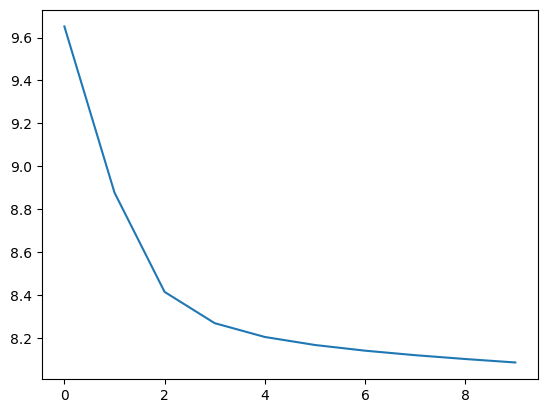

In [20]:
plt.plot(running_loss)

In [50]:
wordvecs = model.expand.weight.cpu().detach().numpy()
tokens = ['штирлиц', 'мама', 'жен', 'проститутк']

In [51]:
from scipy.spatial import distance

In [52]:
def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

def get_k_similar_words(word, dist_matrix, k=10):
    idx = tok2id[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, id2tok[i], dists[i]) for i in ind]
    return out

dmat = get_distance_matrix(wordvecs, 'cosine')
for word in tokens:
    print(word, [t[1] for t in get_k_similar_words(word, dmat)], "\n")

штирлиц ['увидел', 'вышел', 'окн', 'подума', 'сел', 'стоя', 'блин', 'упа', 'немн', 'двер'] 

мама ['мамаев', 'перехват', 'ерш', 'дурк', 'норильск', 'кулич', 'коньячок', 'экспертиз', 'присест', 'оговор'] 

жен ['муж', 'дорог', 'мо', 'говор', 'дом', 'сво', 'сказа', 'теб', 'сраз', 'дума'] 

проститутк ['собира', 'секс', 'долж', 'девушк', 'хоч', 'теб', 'хот', 'плат', 'знаком', 'женщин'] 



In [25]:
torch.save(model.state_dict(), 'word2vec-twitter_hate-1epoch.checkpoint')

In [ ]:
#model = Word2Vec(n_v, EMBED_SIZE)
#model.load(torch.load('word2vec-twitter_hate-1epoch.checkpoint'))